## Import package

In [1]:
!pip install scikit-image
!pip install opencv-python-headless

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import csv
import re
import math as m
import cv2

import skimage
import skimage.feature
import skimage.measure

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

     |████████████████████████████████| 29.2 MB 25.9 MB/s 
     |████████████████████████████████| 3.3 MB 32.8 MB/s 
     |████████████████████████████████| 1.6 MB 16.3 MB/s 
     |████████████████████████████████| 4.4 MB 16.9 MB/s 
     |████████████████████████████████| 169 kB 12.3 MB/s 
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Not uninstalling decorator at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
     |████████████████████████████████| 37.1 MB 386 kB/s 


## 1. Initialization

### 1.1 Loading the image and setting parameters

In [2]:
img = Image.open("pics/7.jpg")

In [3]:
# Size of the final pattern 
w, h = img.size
num_w = 100  # Input: number of threads in a row
block_size = w // num_w
num_h = h * num_w // w # Number of threads in a column

# Colours in the palette
K = 50  # If the number of colours in the final pattern is decided by users

### 1.2 Obtaining RGB and luminosity of an image

In [4]:
# Resize the image so that it can be divided into `num_w*num_h` blocks.
width, height = num_w*block_size, num_h*block_size
img = img.resize((width, height))
img_np =  np.asarray(img)
img_grey = np.array(img.convert('L'),'f')

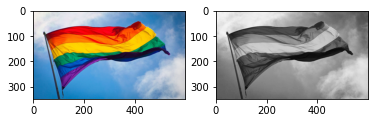

In [5]:
plt.subplot(121)
plt.imshow(img_np) 
plt.subplot(122)
plt.imshow(img_grey, cmap='gray')

### 1.3 Getting DMC infomation

In [6]:
with open('DMC_RGB.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]

pattern = re.compile(r".*<td>(.*?)</td>")
data_all = []
for line in rows:
    content = ''.join(line)
    if re.match(r"(.*)<td>(.*?)</td>", content):
        data = re.search(pattern, content)
        data_all.append(data.group(1))

floss = data_all[::7]
name = data_all[1::7]
Red = data_all[2::7]
Green = data_all[3::7]
Blue = data_all[4::7]
RGB_code = data_all[5::7]
row = data_all[6::7]

dmc_rgb = {"floss": floss,\
"name": name, \
"Red": list(map(int,Red)), \
"Green": list(map(int,Green)), \
"Blue": list(map(int,Blue)), \
"RGB_code": RGB_code, \
"row": row}
dmc_rgb = pd.DataFrame(dmc_rgb)

rgb_matrix = dmc_rgb[["Red","Green","Blue"]]

### 1.4 Three types of objective functions

In [105]:
def obj1(x1,x2):
    return np.linalg.norm(x1 - x2, ord = 1)

def obj2(x1,x2):
    return np.linalg.norm(x1 - x2)

def obj3(x1,x2):
    r1,g1,b1 = x1[0], x1[1], x1[2]
    r2,g2,b2 = x2[0], x2[1], x2[2]
    d =  m.sqrt(((r2-r1)*0.30)**2 + ((g2-g1)*0.59)**2 + ((b2-b1)*0.11)**2)
    return d

## 2. Pixelating the image

### 2.1 Calculating the image entropy

In [7]:
entropy = skimage.measure.shannon_entropy(img)

### 2.2 Finding edges

In [8]:
edges = skimage.feature.canny(img_grey, sigma = 0.5,  low_threshold = 100, high_threshold = 200)

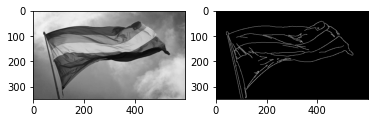

In [9]:
images = [img_grey, edges]
location = [121, 122] 
for loc, edge_image in zip(location, images): 
   plt.subplot(loc) 
   plt.imshow(edge_image, cmap='gray')

### 2.3 Changing blocks

In [10]:
# Output whether a block contains edge pixels
def edge_detection(block_pixels, edges):
    edge_pixels = []
    for pixel in block_pixels:
        if edges[pixel[0], pixel[1]] == True:
            edge_pixels.append(pixel)
    if edge_pixels:
        return edge_pixels
    else:
        return False

def edge_or_not(s, edges):
    if True in edges[s[0]: s[2]+1, s[1]:s[3]+1]:
        return True
    else:
        return False

# Calculating the average RGB of a block
def get_averageRGB(img_array, s, block_size):
  block_img = img_array[s[0]:s[2] + 1, s[1]:s[3] + 1]
  return np.average(block_img.reshape(block_size**2, 3), axis=0).astype(int)

In [11]:
# If the image entropy is low, replace the RGB of a block with 
# the average RGB of all pixels in the block.

def change_block_ave(x, y, block_size, img_array):
    block_pixels = []
    block_sides = [x, y, x + block_size - 1, y + block_size - 1]
    for i in range(block_size):
        for j in range(block_size):
            block_pixels.append([x + i, y + j])
    new_color = get_averageRGB(img_array, block_sides, block_size)
    return block_pixels, new_color


# If the image entropy is high, replace the RGB of a block with 
# the average RGB of all pixels in the block when the block contains edge pixels,
# and with the average RGB of the colours that appear most in the block 
# when the block does not contain any edge pixel.

def change_block(x, y, block_size, img_array, edges):
    block_pixels = []
    block_sides = [x, y, x + block_size - 1, y + block_size - 1]
    for i in range(block_size):
        for j in range(block_size):
            block_pixels.append([x + i, y + j])

    if edge_or_not(block_sides, edges):   
        color_dict = {}
        colors = {}
        for pixel in block_pixels:
            if not str(img_array[pixel[0], pixel[1]]) in color_dict.keys():
                color_dict[str(img_array[pixel[0], pixel[1]])] = 1
                colors[str(img_array[pixel[0], pixel[1]])] = img_array[pixel[0], pixel[1]]
            else:
                color_dict[str(img_array[pixel[0], pixel[1]])] += 1
        max_color_num = max(color_dict.values())
        max_color = [k for k,v in color_dict.items() if v == max_color_num]
        max_color_list = np.array([v for k,v in colors.items() if k in max_color])
        new_color = np.average(np.array(max_color_list), axis = 0).astype(int)
    else:
        new_color = get_averageRGB(img_array, block_sides, block_size)
    return block_pixels, new_color

In [12]:
en_threshold = 5

In [13]:
img_new = img_np.copy()
img_np_resized = np.zeros((num_h, num_w, 3))
for x in range(0,height,block_size):
    for y in range(0,width,block_size):
        if entropy > en_threshold:
            block_pixels = change_block(x, y, block_size, img_np, edges)[0]
            block_color = change_block(x, y, block_size, img_np, edges)[1]
        else:
            block_pixels = change_block_ave(x, y, block_size, img_np)[0]
            block_color = change_block_ave(x, y, block_size, img_np)[1]
        img_np_resized[int(x/block_size)][int(y/block_size)] = block_color
        for pixel in block_pixels:
            img_new[pixel[0], pixel[1]] = block_color

In [14]:
img_resized = img_np_resized.astype('uint8')

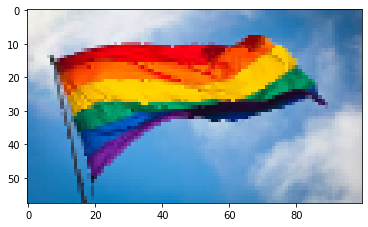

In [15]:
plt.imshow(img_resized)

## 3. Deciding palette

### 3.1 Given the number of colours in the final pattern

In [16]:
palette_num = rgb_matrix.shape[0]

In [17]:
dist_threshold = 20

#### 3.1.1 Initializing the palette

In [18]:
init_num = 100

In [19]:
rgb_count = []
for i in range(palette_num):
    c_i = np.array(rgb_matrix.loc[i])
    n_i = 0
    for row in range(num_h):
        for col in range(num_w):
            x = img_resized[row][col]
            dist = np.linalg.norm(x - c_i)
            if dist <= dist_threshold:
                n_i += 1
    rgb_count.append(n_i)

In [20]:
rgb_palette = dmc_rgb.copy()
rgb_palette["count"] = rgb_count

In [21]:
rgb_sorted = rgb_palette.sort_values(by = ["count"], ascending = False)
rgb_init = rgb_sorted.head(init_num).reset_index()

In [47]:
initial_palette_rgb = rgb_init[["Red","Green","Blue"]]

#### 3.1.2 Generating the palette with given number of colours

In [64]:
# Given a DMC colour i in the initial palette `rgb_init`, measure the importance of the colour
# combining the number of pixels falling in its neighbourhood
# and its closest distance to the colours that are already selected.

def cal_distN(i,palette,rgb_df,initn):
    rgb = rgb_df[["Red","Green","Blue"]]
    colour_palette = np.array(rgb.iloc[palette])
    c_i = np.array(rgb.iloc[i])
    all_dist = list(map(lambda x: np.linalg.norm(x - c_i), colour_palette))
    Dist_i = min(all_dist) ** 2
    distN = Dist_i * m.sqrt(initn[i])
    return distN

In [23]:
palette_index = []
Selected = [0] * 100
palette_index.append(0)
Selected[0] = 1
initn = rgb_init["count"]
Cno = 1

In [26]:
while Cno < K:
    not_selected = []
    for i in range(100):
        if Selected[i] == 0:
            not_selected.append(i)
    all_distN = list(map(lambda x: cal_distN(x,palette_index,rgb_init,initn), not_selected))
    which_max = all_distN.index(max(all_distN))
    j = not_selected[which_max]
    palette_index.append(j)
    Selected[j] = 1
    Cno += 1

In [36]:
final_palette = rgb_init.iloc[palette_index].reset_index()
final_palette_rgb = final_palette[["Red","Green","Blue"]]

### 3.2 Given a set of colours in the same colour family

In [137]:
def rgb2grey(pixel):
    (b, g, r) = pixel
    b = int(b)
    g = int(g)
    r = int(r)
    gray = r*0.299 + g*0.587 + b*0.114
    return(gray)

img_resized_grey = np.zeros([num_h, num_w], np.uint8)
for i in range(num_h):
    for j in range(num_w):
        pixel = img_resized[i, j]
        gray = rgb2grey(pixel)
        img_resized_grey[i, j] = np.uint8(gray)

In [206]:
chosen_palette = dmc_rgb[dmc_rgb['row'].str.contains("row 01")]
# chosen_palette = dmc_rgb.head(30)
chosen_palette_rgb = chosen_palette[["Red","Green","Blue"]]

In [207]:
chosen_palette_lu = []
for color in np.array(chosen_palette_rgb):
    gray = rgb2grey(color)
    chosen_palette_lu.append(np.uint8(gray))

chosen_palette_lu = np.array(chosen_palette_lu).astype(int)

## 4. Finding optimal pattern

In [121]:
img_converted_1 = img_resized.copy()

In [127]:
for row in range(num_h):
    for col in range(num_w):
        c = img_resized[row][col]
        all_dist = list(map(lambda x: obj2(x,c), np.array(final_palette_rgb)))
        which_min = all_dist.index(min(all_dist))
        change = np.array(final_palette_rgb.iloc[which_min])
        img_converted_1[row][col] = change

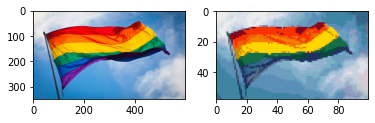

In [128]:
plt.subplot(121)
plt.imshow(img_np) 
plt.subplot(122)
plt.imshow(img_converted_1)

### 4.2 Optimising over the full set of colours with k-means colour quantization

In [117]:
img_converted_2_0 = img_resized.copy()

In [118]:
def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [119]:
for row in range(num_h):
    for col in range(num_w):
        c = img_resized[row][col]
        all_dist = list(map(lambda x: obj3(x,c), np.array(rgb_matrix)))
        which_min = all_dist.index(min(all_dist))
        change = np.array(rgb_matrix.iloc[which_min])
        img_converted_2_0[row][col] = change

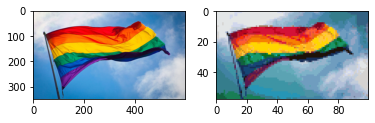

In [120]:
img_converted_2_1 = img_converted_2_0 / 255
w, h, d = original_shape = tuple(img_converted_2.shape)
assert d == 3
image_array = np.reshape(img_converted_2_1, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters = K, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

img_converted_2 = recreate_image(kmeans.cluster_centers_, labels, w, h)

plt.subplot(121)
plt.imshow(img_np) 
plt.subplot(122)
plt.imshow(img_converted_2)

### 4.3 Optimising based on luminosity

In [210]:
img_converted_3 = img_resized.copy()
for row in range(num_h):
    for col in range(num_w):
        lu = img_resized_grey[row][col]
        all_lu_dist = abs(chosen_palette_lu - lu).tolist()
        which_min_lu = all_lu_dist.index(min(all_lu_dist))
        change_lu = np.array(chosen_palette_rgb.iloc[which_min_lu])
        img_converted_3[row][col] = change_lu

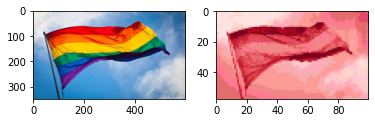

In [211]:
plt.subplot(121)
plt.imshow(img_np) 
plt.subplot(122)
plt.imshow(img_converted_3)

## 5. Image Quality Assessment

### 5.1 Entropy

In [212]:
skimage.measure.shannon_entropy(img_converted_1)

5.8964749725591075

In [213]:
skimage.measure.shannon_entropy(img_converted_2)

6.679675697550409

In [214]:
skimage.measure.shannon_entropy(img_converted_3)

4.91505979380487

### 5.2 PSNR

In [226]:
baseline = cv2.resize(img_np, (num_w,num_h))

In [229]:
def psnr(img1, img2):
    mse = np.mean((img1-img2)**2)
    if mse == 0:
        return 100
    else:
        L = 255.0 # L:maximum pixel value
        return 10*m.log10(L*L/mse)

In [233]:
psnr(baseline, img_converted_1)

29.826203796233436

In [234]:
psnr(baseline, img_converted_2)

3.9504270354012605

In [232]:
psnr(baseline, img_converted_3)

28.377732354591025

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=768076c7-65ce-42d5-b86d-074f9f75d785' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>